In [1]:
import tensorflow.keras
from homemade_unet import unet_model_3d


In [2]:
input_shape = (1,64,64,64)
model = unet_model_3d(input_shape = input_shape, n_labels = 3)
#model.summary()

In [1]:
from data import get_balanced_train_and_validation_datasets

batch_size = 1
path_images = '/home/jaume/Documentos/DL_postgraduate/final_project/sample_data/imagesTr/'
path_labels = '/home/jaume/Documentos/DL_postgraduate/final_project/sample_data/labelsTr/'

train_dataset, validation_dataset, validation_images = get_balanced_train_and_validation_datasets(0.2,path_images,path_labels,patch_shape=(64,64,64),validation_shape=(128,128,128),subsample=10,mask=True,repetitions=2,seed=111)
train_dataset = train_dataset.shuffle(10).batch(batch_size).prefetch(2)
validation_dataset = validation_dataset.shuffle(10).batch(batch_size).prefetch(2)


Subsampling with images: ['pancreas_028.nii.gz', 'pancreas_050.nii.gz', 'pancreas_019.nii.gz', 'pancreas_006.nii.gz', 'pancreas_051.nii.gz', 'pancreas_049.nii.gz', 'pancreas_029.nii.gz', 'pancreas_018.nii.gz', 'pancreas_021.nii.gz', 'pancreas_048.nii.gz']
Number of images for training: 8
Number of images for validation: 2


In [13]:
from utils.callback_functions import ShowEverythingCallback
import tensorflow as tf

file_writer = tf.summary.create_file_writer('images')
callback = ShowEverythingCallback(train_dataset,validation_dataset,file_writer,num_images=3)

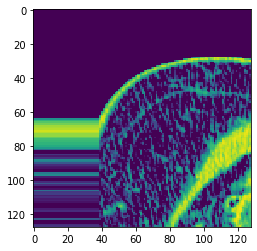

In [11]:
img = callback.return_slice()
import pylab as plt
plt.imshow(img)

In [8]:
for image in validation_dataset:
    x,y = image
    print(x.shape)
    print(y.shape)
    break

(1, 1, 128, 128, 128)
(1, 3, 128, 128, 128)


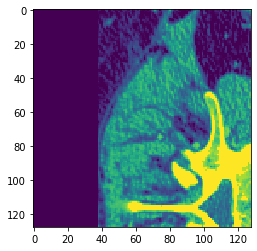

In [11]:
import pylab as plt
plt.imshow(x[0,0,:,:,30])

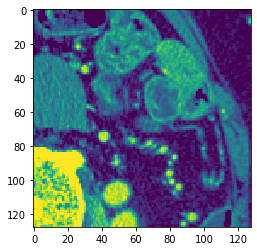

In [44]:
import pylab as plt
plt.imshow(x[0,0,:,:,10])

In [ ]:
for batch in train_dataset:
    for i in range(batch[0].shape[0]):
        x = batch[0][i,:,:,:,:]
        y = batch[1][i,:,:,:,:]
        print(x.shape)
        print(y.shape)
        break
    break

In [ ]:
import pylab as plt

plt.imshow(x[0,0,:,:,50])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from datetime import datetime
from utils.callback_functions import ShowPredictionsCallback
import tensorflow as tf

time = datetime.now().strftime('%Y-%m-%d_%H-%M')

file_writer = tf.summary.create_file_writer('runs/images')


show_predictions = ShowPredictionsCallback(validation_images,path_images,path_labels,file_writer)

model_checkpoint = ModelCheckpoint(filepath='models/best/' + time + '_model_weights.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True)

reduce_lr_plateau = ReduceLROnPlateau(monitor='val_loss', 
                                      patience=10, 
                                      verbose=1)

tensorboard_callback = TensorBoard(log_dir='runs/' + time,
                                   write_grads=True)

callbacks = [model_checkpoint,reduce_lr_plateau,tensorboard_callback]
callbacks = [show_predictions]


In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from datetime import datetime
from utils.callback_functions import ShowPredictionsCallback
import tensorflow as tf
from metrics import generalized_dice_loss

loss = generalized_dice_loss()

file_writer = tf.summary.create_file_writer('runs/images')

show_predictions = ShowPredictionsCallback(train_dataset,validation_dataset,file_writer,loss=loss,num_images=1)
callbacks=[show_predictions]


In [ ]:
import numpy as np
import tensorflow as tf
import nibabel as nib

path_img = '/home/jaume/Documentos/DL_postgraduate/final_project/sample_data/labelsTr/' + validation_images[0]

img = nib.load(path_img)

img = np.array(img.dataobj)

img = img[:,:,30]

import pylab as plt

#plt.imshow(img*512)


img = np.expand_dims(img,axis=0)
img = np.expand_dims(img,axis=-1)

img = (255*(img/2)).astype(np.uint8)

logdir = "runs/images"
# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(logdir)

# Using the file writer, log the reshaped image.
with file_writer.as_default():
  tf.summary.image("Validation data", tf.convert_to_tensor(img), step=0)


In [5]:
epochs = 1
model.fit(train_dataset,
          epochs=epochs,
          validation_data=validation_dataset,
          callbacks = callbacks)

Loss train 1:tf.Tensor(-0.0034356453, shape=(), dtype=float32)
Loss validation 1:tf.Tensor(-0.0026824984, shape=(), dtype=float32)
      1/Unknown - 106s 106s/step - loss: 0.8963

KeyboardInterrupt: 

In [ ]:
model.save_weights("models/final/" + time + "_model_weights.h5")